In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import word_tokenize
import langdetect
from sklearn import feature_extraction, model_selection
import gensim
import gensim.downloader as gensim_api

from tqdm import tqdm
import pickle as pkl
import os
import transformers
from transformers import BertTokenizer, BertModel
import torch

# Dataset:

We will be using the News Category Dataset. This dataset contains around 200k news headlines from the year 2012 to 2018 obtained from HuffPost. Each news headline has a corresponding category. The original dataset has 30 categories. To keep this tutorial simple, we will look at 3 categories: Entertainment, Politics and Tech.

Download link: https://www.kaggle.com/datasets/rmisra/news-category-dataset

## Reading Data

In [3]:
lst_dics = []
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        lst_dics.append( json.loads(dic) )

## print the first one
lst_dics[0]

{'category': 'CRIME',
 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 'authors': 'Melissa Jeltsen',
 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89',
 'short_description': 'She left her husband. He killed their children. Just another day in America.',
 'date': '2018-05-26'}

In [4]:
## create dtf
dtf = pd.DataFrame(lst_dics)
## filter categories
dtf = dtf[ dtf["category"].isin(['ENTERTAINMENT','POLITICS','TECH']) ][["category","headline"]]
## rename columns
dtf = dtf.rename(columns={"category":"label", "headline":"text"})
## print 5 random rows
dtf.sample(5)

,label,text
55472,POLITICS,Political Leaders React To Senate Gun Control ...
99149,ENTERTAINMENT,Kanye Performed Twice During The Grammys
8435,TECH,Silicon Valley's Problematic Sex Parties On Bl...
178120,TECH,Why Facebook and YouTube Should Err on the Sid...
101007,POLITICS,"Corporate Contributions (of Beer, Cash, or Any..."


In [5]:
len(dtf)

50879

## Data Analysis

The below plot shows the distribution of the data over the different categories.

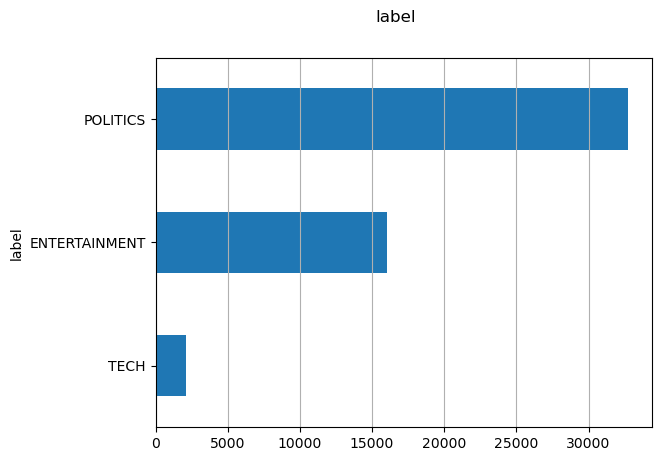

In [6]:
fig, ax = plt.subplots()
fig.suptitle("label", fontsize=12)
dtf["label"].reset_index().groupby("label").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

The dataset is imbalanced: the proportion of Tech news is really small compared to the others, this will make for models to recognize Tech news rather tough.

## Dataset Pre-processing

### Removing non-english sentences

In [7]:
def add_detect_lang(data, column):
    dtf = data.copy()
    dtf['lang'] = dtf[column].apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")
    return dtf

In [8]:
dtf = add_detect_lang(dtf, 'text')
dtf.head()

,label,text,lang
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en


In [9]:
# filter english only
dtf = dtf[dtf["lang"]=="en"]
len(dtf) #should reduce from original length = 50879

48949

### Lower-casing and removal of punctuations and characters

In [10]:
text = 'Jack ran quickly to the stumps.'

In [11]:
#using regex
text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
text

'jack ran quickly to the stumps'

### Tokenization

In [12]:
lst_text = word_tokenize(text)
lst_text

['jack', 'ran', 'quickly', 'to', 'the', 'stumps']

### Stopword Removal

In [13]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [14]:
if lst_stopwords is not None:
    lst_text = [word for word in lst_text if word not in lst_stopwords] #list comprehension
lst_text

['jack', 'ran', 'quickly', 'stumps']

### Stemming

In [15]:
ps = nltk.stem.porter.PorterStemmer()
lst_text_stem = [ps.stem(word) for word in lst_text]
lst_text_stem

['jack', 'ran', 'quickli', 'stump']

### Lemmatization

In [16]:
lem = nltk.stem.wordnet.WordNetLemmatizer()
nltk.download('wordnet') #need to uncomment once to download wordnet - required by lemmatizer
lst_text_lem = [lem.lemmatize(word) for word in lst_text]
lst_text_lem

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/debanjana_kar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['jack', 'ran', 'quickly', 'stump']

### Putting it all together as a function

In [17]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [18]:
clean_text = [utils_preprocess_text(row["text"], flg_stemm=False,  
          flg_lemm=True, lst_stopwords=lst_stopwords) for idx, row in dtf.iterrows()]
dtf["text_clean"] = clean_text
dtf.head()

,label,text,lang,text_clean
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,en,smith join diplo nicky jam 2018 world cup offi...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,en,hugh grant marries first time age 57
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,en,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,en,julianna margulies us donald trump poop bag pi...
5,ENTERTAINMENT,Morgan Freeman 'Devastated' That Sexual Harass...,en,morgan freeman devastated sexual harassment cl...


In [19]:
clean_text[:10]

['smith join diplo nicky jam 2018 world cup official song',
 'hugh grant marries first time age 57',
 'jim carrey blast castrato adam schiff democrat new artwork',
 'julianna margulies us donald trump poop bag pick dog',
 'morgan freeman devastated sexual harassment claim could undermine legacy',
 'donald trump lovin new mcdonalds jingle tonight show bit',
 'watch amazon prime thats new week',
 'mike myers reveals hed like fourth austin power film',
 'watch hulu thats new week',
 'justin timberlake visit texas school shooting victim']

## Dataset Splitting

In [20]:
dtf_train, dtf_test = model_selection.train_test_split(dtf, test_size=0.3)
len(dtf_train), len(dtf_test)

(34264, 14685)

In [21]:
corpus = dtf_train["text_clean"]
x_train = dtf_train["text_clean"].values
x_test = dtf_test["text_clean"].values
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [22]:
#save dataset splits
with open('dataset.pkl', 'wb') as pkl_out:
    pkl.dump(x_train, pkl_out)
    pkl.dump(y_train, pkl_out)
    pkl.dump(x_test, pkl_out)
    pkl.dump(y_test, pkl_out)

## Text Representations

### Count Vectors

In [23]:
## Count (classic BoW)
count_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000, ngram_range=(1,2))
count_vectorizer.fit(corpus)
corpus_count_vectors = count_vectorizer.transform(corpus)
dic_vocabulary = count_vectorizer.vocabulary_

In [24]:
corpus_count_vectors, dic_vocabulary

(<34264x10000 sparse matrix of type '<class 'numpy.int64'>'
 	with 274813 stored elements in Compressed Sparse Row format>,
 {'cruz': 2142,
  'likely': 5159,
  'block': 1059,
  'trump': 9041,
  'second': 7810,
  'ballot': 766,
  'gop': 3704,
  'convention': 1967,
  'block trump': 1061,
  'trump second': 9220,
  'gop convention': 3712,
  'ally': 385,
  'reaction': 7045,
  'breakfast': 1166,
  'club': 1757,
  'makeover': 5359,
  'show': 8030,
  'time': 8849,
  'changed': 1527,
  'scott': 7766,
  'hit': 4108,
  'fan': 3153,
  'czar': 2189,
  'american': 418,
  'hero': 4064,
  'give': 3643,
  'kkk': 4891,
  'soundtrack': 8225,
  'deserves': 2452,
  'director': 2533,
  'sign': 8060,
  'hill': 4090,
  'cop': 1983,
  'house': 4178,
  'crackdown': 2086,
  'continues': 1955,
  'house gop': 4189,
  'new': 5940,
  'york': 9952,
  'city': 1665,
  'jewish': 4626,
  'organization': 6281,
  'received': 7088,
  'threat': 8809,
  'week': 9703,
  'new york': 6001,
  'york city': 9953,
  'jimmy': 4635,
 

### TF-IDF Embeddings

In [25]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))
vectorizer.fit(corpus)
corpus_tfidf_vectors = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [26]:
corpus_tfidf_vectors

<34264x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 274813 stored elements in Compressed Sparse Row format>

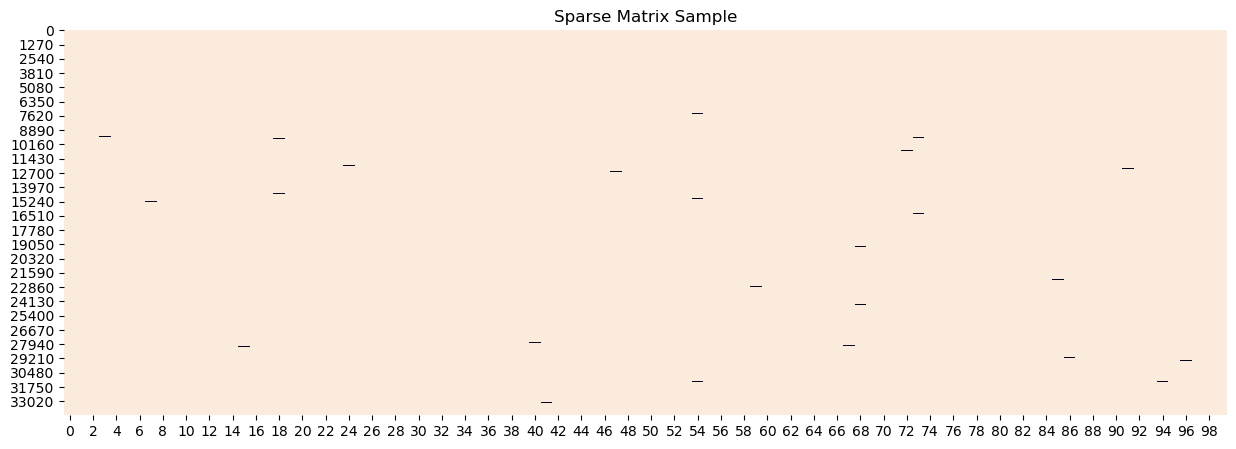

In [27]:
##Plot tf-idf vectors
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(corpus_tfidf_vectors.todense()
            [:,np.random.randint(0,corpus_tfidf_vectors.shape[1],100)]==0, vmin=0, vmax=1, 
            cbar=False).set_title('Sparse Matrix Sample')
plt.show()

### Word2Vec Embeddings

In [28]:
#load pretrained word2vec vectors
nlp = gensim_api.load("word2vec-google-news-300")

In [29]:
nlp.most_similar("cat")

[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464984655380249),
 ('feline', 0.7326233983039856),
 ('beagle', 0.7150582671165466),
 ('puppy', 0.7075453996658325),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931377410889),
 ('chihuahua', 0.6709762215614319)]

In [30]:
nlp.most_similar("car")

[('vehicle', 0.7821096181869507),
 ('cars', 0.7423830032348633),
 ('SUV', 0.7160962224006653),
 ('minivan', 0.6907036304473877),
 ('truck', 0.6735789775848389),
 ('Car', 0.6677608489990234),
 ('Ford_Focus', 0.6673202514648438),
 ('Honda_Civic', 0.6626849174499512),
 ('Jeep', 0.651133120059967),
 ('pickup_truck', 0.6441437602043152)]

In [31]:
#view one word vector
nlp['car'].shape, nlp['car']

((300,),
 array([ 0.13085938,  0.00842285,  0.03344727, -0.05883789,  0.04003906,
        -0.14257812,  0.04931641, -0.16894531,  0.20898438,  0.11962891,
         0.18066406, -0.25      , -0.10400391, -0.10742188, -0.01879883,
         0.05200195, -0.00216675,  0.06445312,  0.14453125, -0.04541016,
         0.16113281, -0.01611328, -0.03088379,  0.08447266,  0.16210938,
         0.04467773, -0.15527344,  0.25390625,  0.33984375,  0.00756836,
        -0.25585938, -0.01733398, -0.03295898,  0.16308594, -0.12597656,
        -0.09912109,  0.16503906,  0.06884766, -0.18945312,  0.02832031,
        -0.0534668 , -0.03063965,  0.11083984,  0.24121094, -0.234375  ,
         0.12353516, -0.00294495,  0.1484375 ,  0.33203125,  0.05249023,
        -0.20019531,  0.37695312,  0.12255859,  0.11425781, -0.17675781,
         0.10009766,  0.0030365 ,  0.26757812,  0.20117188,  0.03710938,
         0.11083984, -0.09814453, -0.3125    ,  0.03515625,  0.02832031,
         0.26171875, -0.08642578, -0.02258

In [32]:
#length of the vocabulary
len(nlp.index_to_key)

3000000

### Embedding Corpus for W2V

In [33]:
def transform(X):
    X_embeddings = np.array([get_embedding(words) for words in tqdm(X)])
    return X_embeddings

def get_embedding(words, size=300):
    valid_words = [word for word in words if word in nlp.index_to_key]
    if valid_words:
        embedding = np.zeros((len(valid_words), size), dtype=np.float32) #padding; fixed length=300
        for idx, word in enumerate(valid_words):
            embedding[idx] = nlp[word]

        return np.mean(embedding, axis=0)
    else:
        return np.zeros(size)

In [34]:
#takes a lot of time, already provided as pkl files
#train_embed = transform(x_train)
#train_embed.shape

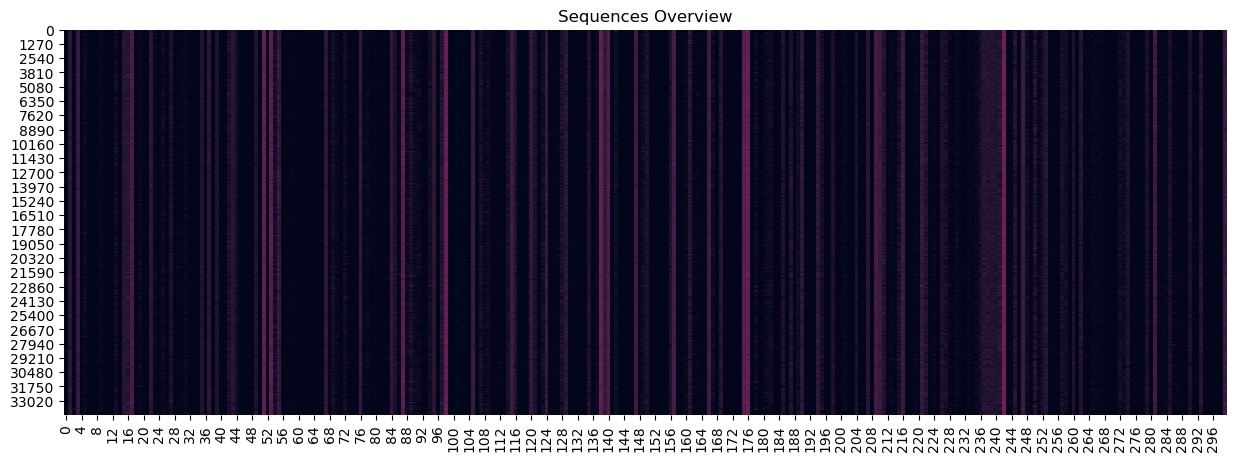

In [109]:
#plot w2v embeddings for train set
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(train_embed, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Sequences Overview')
plt.show()

In [35]:
#uncomment to run, else use pre-computed vectors provided as pkl files
#test_embed = transform(x_test)
#test_embed.shape

In [111]:
## storing the embeddings
#if not os.path.exists('vectors'):
#    os.makedirs('vectors')

#with open('vectors/w2v.pkl', 'wb') as pkl_out:
#    pkl.dump(train_embed, pkl_out)
#    pkl.dump(test_embed, pkl_out)

## BERT Embeddings

In [36]:
## bert tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
## bert model
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [38]:
## return hidden layer with embeddings
text = "Hello, my dog is cute"

##tokenize and map words to ids
inputs = tokenizer(text, return_tensors="pt")

## print tokenized output
tokenizer.tokenize(text)

['hello', ',', 'my', 'dog', 'is', 'cute']

In [39]:
inputs['input_ids'][0]

tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102])

In [40]:
#check what each token id corresponds to after tokenization
tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

['[CLS]', 'hello', ',', 'my', 'dog', 'is', 'cute', '[SEP]']

In [41]:
#embed tokenized text
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state
last_hidden_states.shape

torch.Size([1, 8, 768])